# Post Process Predictions
Optimize keypoint position s.t. a set of constraints using Projected Gradient Descent.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_pose.postprocess.projected_gd import ProjectedGD
from torchtyping import TensorType
from omegaconf import DictConfig
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.utils.io import return_absolute_data_paths
import hydra
import os
import pandas as pd
import cvxpy as cp

In [2]:
def MSE(preds: TensorType["num_samples", "num_keypoints",2],
        gt: TensorType["num_samples", "num_keypoints",2]):
    bp_error = torch.linalg.norm(preds - gt, dim=2) # error per keypoint-frame
    #average_error = torch.mean(bp_error, dim=1) # mean over keypoints
    return bp_error

In [3]:
def get_base_config(config_dir: str, config_name: str) -> DictConfig:
    assert(os.path.isdir(config_dir))
    hydra.initialize_config_dir(base_config_dir)
    cfg = hydra.compose(config_name="config")
    return cfg
from typing import List
def get_keypoint_names(csv_data: pd.DataFrame, header_rows: List[int]) -> List[str]:
    if header_rows == [0,1,2]:
        keypoint_names = [c[1] for c in csv_data.columns[1::2]]
    elif header_rows == [1,2]:
        keypoint_names = [c[0] for c in csv_data.columns[1::2]]
    return keypoint_names

In [4]:
dataset_name = "rick-configs-1"
# dataset_name = "ibl-pupil-2"
# dataset_name = "ibl-paw-2"
base_config_dir = "/home/jovyan/rick-configs-1"
base_save_dir = "/home/jovyan/"

# hydra.initialize_config_dir(base_config_dir)
# cfg = hydra.compose(config_name="config")
cfg = get_base_config(base_config_dir, "config")



In [5]:
# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

In [52]:
# load pca singleview preds
pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-27/01-17-25/0/predictions.csv"
pred_df = pd.read_csv(pred_file, header=[0, 1, 2], index_col=0)
if pred_df.keys()[-1][0] == "set":
    # these are predictions on labeled data; get rid of last column that
    # contains info about train/val/test set
    is_video = False
    tmp = pred_df.iloc[:, :-1].to_numpy().reshape(pred_df.shape[0], -1, 3)
keypoints_pred = tmp[:, :, :2]  # shape (samples, n_keypoints, 2)
confidences = tmp[:, :, -1]  # shape (samples, n_keypoints)
print(keypoints_pred.shape)
#ground_truth_df = pd.read_csv("/datastores/mouseRunningData/CollectedData_.csv", header=[1,2])

(1045, 17, 2)


In [53]:
confidences.shape

(1045, 17)

In [7]:
# save_dir = os.path.join(base_save_dir, dataset_name)
save_dir = "/home/jovyan/lightning-pose"

loss_type = "pca_singleview" # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
to_compute = "rmse" # rmse | pca_multiview | pca_singleview | unimodal_mse
model_name = "supervised-heatmap-75"
train_frames = 75 # 000
#pca_singleview_epsilon = 15.
#pca_multiview_epsilon = None
#empirical_epsilon_multiplier = 1.0 # can hack this if want to sweep over multipliers/losses
model_type = "heatmap"
#rng_seed = 42
# temporal_epsilon = 9.8 # hack for now
#loss_weight_dict['pca_singleview'].sort(reverse=True)

pca_loss = None
datamodule = None
model_cfg = cfg.copy()
model_cfg.training.train_frames = train_frames
model_cfg.model.losses_to_use = [loss_type]
from lightning_pose.utils.pca import KeypointPCA
data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
data_module.setup()
# compute pca params
loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]
# store results here
if to_compute == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
cols_collected = []

Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 104, test set: 105


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.
[/opt/dali/dali/operators/reader/nvdecoder/nvdecoder.cc:82] Warning: Decoding on a default stream. Performance may be affected.


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 104, test set: 105
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


In [8]:
pca_loss.pca

In [9]:
def resize_keypoints(cfg, keypoints_pred):
    """reshape to training dims for pca losses, which are optimized for these dims"""
    x_resize = cfg.data.image_resize_dims.width
    x_og = cfg.data.image_orig_dims.width
    keypoints_pred[:, :, 0] = keypoints_pred[:, :, 0] * (x_resize / x_og)
    # put y vals back in original pixel space
    y_resize = cfg.data.image_resize_dims.height
    y_og = cfg.data.image_orig_dims.height
    keypoints_pred[:, :, 1] = keypoints_pred[:, :, 1] * (y_resize / y_og)
    return keypoints_pred

In [54]:
# resize both arrays to training dims
keypoints_pred = resize_keypoints(model_cfg, keypoints_pred)
keypoints_gt = resize_keypoints(model_cfg, keypoints_gt)

In [55]:
# remove redundant keypoints for pca singleview
#pca_cols = pca_loss.pca.columns_for_singleview_pca
keypoints_pred = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_pred).reshape(keypoints_pred.shape[0], -1))
keypoints_gt = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_gt).reshape(keypoints_gt.shape[0], -1))


/tmp/ipykernel_11281/592071754.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keypoints_gt = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_gt).reshape(keypoints_gt.shape[0], -1))


IndexError: index 14 is out of bounds for dimension 0 with size 14

In [12]:
print(keypoints_gt.shape)
print(keypoints_pred.shape)

torch.Size([1045, 28])
torch.Size([1045, 28])


In [38]:
proj_gd = ProjectedGD(data=keypoints_pred.to("cuda", dtype=pca_loss.pca.parameters["mean"].dtype), \
    ground_truth=keypoints_gt.to("cuda", dtype=pca_loss.pca.parameters["mean"].dtype), \
    proj_params={"pca_singleview": pca_loss.pca}, lr=None, max_iter=4000, tol=1e-3, verbose=False)


In [39]:
# fit
out = proj_gd.fit()

100%|██████████| 4000/4000 [00:05<00:00, 673.77it/s]


In [41]:
err_list = [err.unsqueeze(-1) for err in proj_gd.error_list]

In [42]:
err_list[0].shape

torch.Size([1045, 1])

In [43]:
out = torch.hstack(err_list)

In [44]:
out = out.detach().cpu().numpy()

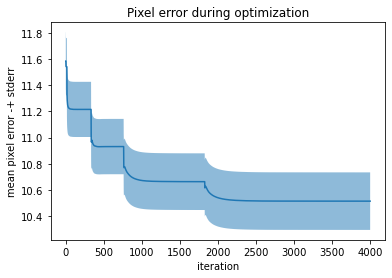

In [48]:
%matplotlib inline
mean = np.mean(out, axis=0)
stderr = np.std(out, axis=0) / np.sqrt(out.shape[0])
plt.plot(np.mean(out, axis=0))
plt.fill_between(np.arange(len(mean)), mean - stderr, mean + stderr, alpha=0.5)
plt.xlabel('iteration')
plt.ylabel('mean pixel error -+ stderr')
save_dir = "/home/jovyan"
plt.title("Pixel error during optimization")
plt.savefig(os.path.join(save_dir, "pca_singleview_error_vs_iter.pdf"))

In [27]:
out

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 3.1426055,  3.1426055,  3.1426055, ...,  3.1426055,  3.1426055,
         3.1426055],
       [11.278218 , 11.278218 , 11.278218 , ..., 14.035965 , 14.035965 ,
        14.035965 ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

tensor([[[ 66.7442,  37.7990],
         [162.8132,  67.4593],
         [151.7117,  61.4233],
         ...,
         [ 58.4374, 204.5468],
         [ 34.3833, 210.4543],
         [245.2683, 177.6950]],

        [[ 37.3207,  77.2357],
         [177.8746,  58.4439],
         [176.0794,  73.8363],
         ...,
         [ 39.8484, 195.9745],
         [ 22.2865, 200.0844],
         [245.2894, 177.2753]],

        [[ 93.2913,  73.8146],
         [209.0615,  66.3784],
         [184.7010,  68.9636],
         ...,
         [ 54.1263, 216.9473],
         [ 33.1530, 236.7531],
         [245.7558, 181.3655]],

        ...,

        [[106.7211,  66.0126],
         [208.4263,  59.0834],
         [145.7761,  66.3464],
         ...,
         [ 59.8686, 142.2760],
         [ 42.8180, 121.8896],
         [245.1495, 179.7290]],

        [[136.4247,  66.2763],
         [164.1049,  73.7205],
         [165.4491,  68.3267],
         ...,
         [ 63.1628, 140.2260],
         [ 43.1016, 122.2235],
         

## CVXPY version
* use norm on desired axis/dims. 
* reshape to go between per bodypart and per frame
* have to reshape differently just to be able to work with 2d mats always and not tensors
* 2d keypoints can be treated independently for the objective
* we just have to reshape them back to num_frames x num_keypoints for the constraints.

In [13]:
test_arr = np.array([[0., 1., 0., 2], [0., 10., 0., 20.], [0., 100., 0., 200.]])
print(test_arr)
test_arr1 = test_arr.reshape(test_arr.shape[0], -1, 2)
test_arr_2 = test_arr.reshape(-1,2)
# can reshape directly to test_arr_2
assert(np.allclose(test_arr_2[1,:], test_arr[0, 2:]))
test_arr_3 = test_arr_2.reshape(test_arr.shape)
assert(np.allclose(test_arr_3, test_arr))

[[  0.   1.   0.   2.]
 [  0.  10.   0.  20.]
 [  0. 100.   0. 200.]]


In [49]:
keypoints_pred = keypoints_pred.detach().cpu().numpy()
keypoints_pred_2d = keypoints_pred.reshape(-1, 2) # shape (samples* n_keypoints, 2)
print(keypoints_pred_2d.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [14]:
# convert pca params to numpy
pca_param_np = {}
for p_name, p_val in pca_loss.pca.parameters.items():
    if isinstance(p_val, torch.Tensor):
        pca_param_np[p_name] = p_val.detach().cpu().numpy()
    else:
        pca_param_np[p_name] = p_val

In [15]:
pca_param_np.keys()

dict_keys(['mean', 'kept_eigenvectors', 'discarded_eigenvectors', 'epsilon'])

In [16]:
from typing import Dict, List, Tuple

In [25]:
def reproject_cvxpy(keypoints, evecs, mean):
    mean = np.tile(mean, (keypoints.shape[0], 1)) # for each sample, repeat mean, to broadcast
    # transform data into low-d space as in scikit learn's _BasePCA.transform()
    # https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/decomposition/_base.py#L97
    centered_data = keypoints - mean
    low_d_projection = centered_data @ evecs.T

    # project back up to observation space, as in scikit learn's _BasePCA.inverse_transform()
    # https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/decomposition/_base.py#L125
    reprojection = low_d_projection @ evecs + mean
    return reprojection
    
def build_pca_constraint(x: cp.Variable, keypoints_orig_shape: Tuple[int,int], pca_param_np: Dict[str, np.array]) -> List[cp.constraints.Inequality]:
    # reshape keypoints 
    #shapes = x.shape
    #out = np.prod(shapes)//2
    #test_arr_f = test_arr.T.reshape(2,out, order='F').T # that's what I should do!
    #x = cp.reshape(x.T, shape=(2, out)).T
    x = cp.reshape(x.T, shape=(keypoints_orig_shape[1], keypoints_orig_shape[0])).T
    print(x)
    # transform data into low-d space as in scikit learn's _BasePCA.transform()
    reconstruction = reproject_cvxpy(x, pca_param_np["kept_eigenvectors"], pca_param_np["mean"])
    recon_err = cp.norm(reconstruction - x, p=2, axis=1)
    return [recon_err <= pca_param_np["epsilon"]]

In [26]:
# build_pca_constraint(x=x, keypoints_orig_shape=keypoints_pred.shape, pca_param_np=pca_param_np)

In [48]:
keypoints_pred_2d = keypoints_pred.reshape(-1, 2) # shape (samples* n_keypoints, 2)

x = cp.Variable(keypoints_pred_2d.shape)
print(x)
#x.value = keypoints_pred_2d.detach().cpu().numpy() # doesn't seem to matter
weights = confidences.reshape(keypoints_pred_2d.shape) #np.ones(shape=(keypoints_pred_2d.shape[0],)) # in the future use actual vals

norm = cp.norm(x - keypoints_pred_2d, p=2, axis=1)
# sum the weighted norms over the samples and keypoints
objective = cp.Minimize(cp.sum(cp.multiply(weights, norm)))

constraints = build_pca_constraint(x=x, keypoints_orig_shape=keypoints_pred.shape, pca_param_np=pca_param_np)

prob = cp.Problem(objective, constraints)
print(prob)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.


var84


ValueError: cannot reshape array of size 17765 into shape (14630,2)

In [28]:
print("Optimal value", prob.solve())

Optimal value 123356.9091458245


In [29]:
optimized_keypoints = x.value.reshape(keypoints_pred.shape)

In [30]:
optimized_keypoints.shape

(1045, 28)

In [31]:
pred_df["set"].columns.to_flat_index()
#pred_df[pred_df["set"]=="train"]

Index([('Unnamed: 52_level_1', 'Unnamed: 52_level_2')], dtype='object')

In [32]:
eval_cond = "test"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values

In [39]:
img_name = csv_data.iloc[inds_to_use[0],0]#["image_name"]
img_name

'barObstacleScaling1/img10.png'

In [33]:
from PIL import Image

In [35]:
keypoints_gt = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
keypoints_pred = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)

In [36]:
optimized_keypoints = optimized_keypoints.reshape(optimized_keypoints.shape[0], -1, 2)

In [37]:
print(optimized_keypoints.shape)
print(keypoints_pred.shape)
print(keypoints_gt.shape)

(1045, 14, 2)
(1045, 14, 2)
torch.Size([1045, 14, 2])


In [45]:
img_index = 16
img_name = csv_data.iloc[inds_to_use[img_index],0]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")


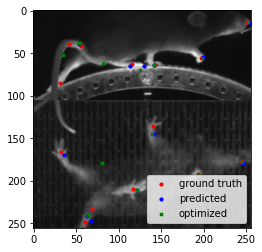

In [46]:
plt.imshow(image.resize((256,256)))
plt.scatter(keypoints_gt[inds_to_use[img_index],:,0], keypoints_gt[inds_to_use[img_index],:,1], s=10, c="r", label="ground truth")
plt.scatter(keypoints_pred[inds_to_use[img_index],:,0], keypoints_pred[inds_to_use[img_index],:,1], s=10, c="b", label="predicted")
plt.scatter(optimized_keypoints[inds_to_use[img_index],:,0], optimized_keypoints[inds_to_use[img_index],:,1], s=10, c="g", label="optimized", marker="x")
plt.legend(loc="lower right")
#plt.savefig('/home/jovyan/figs/first_cvxpy_optim.png')


In [26]:
pred_df["set"].index.values
#pred_df[pred_df.set=="test"]

array([   0,    1,    2, ..., 1042, 1043, 1044])

In [21]:
from lightning_pose.data.utils import DataExtractor

In [22]:
keypoints_tensor, images_tensor = DataExtractor(data_module=data_module, cond="test", extract_images=True)()

In [24]:
keypoints_tensor.shape

torch.Size([105, 34])

In [24]:
(2,3)

AttributeError: 'tuple' object has no attribute 'T'